PyTorch provides the elegantly designed modules and classes:
- `torch.nn`, `torch.optim`, `Dataset`, and `DataLoader` to help you create and train neural networks
- In n order to fully utilize their power and customize them for your problem, you need to really understand exactly what they're doing.

# MNIST data setup

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path('data')
PATH = DATA_PATH/'mnist'

PATH.mkdir(parents=True, exist_ok=True)

URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

if not (PATH/FILENAME).exists():
    content = requests.get(URL+FILENAME).content
    (PATH/FILENAME).open('wb').write(content)

In [49]:
import pickle, gzip

with gzip.open(PATH/FILENAME, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [50]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 784), (50000,), (10000, 784), (10000,))

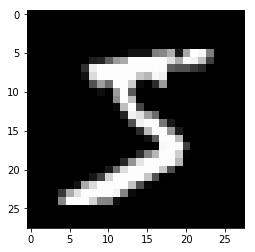

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
plt.show()

PyTorch uses `torch.tensor`, rather than numpy arrays, so we need to convert our data.

In [51]:
import torch

x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor(0),
 tensor(9))

## Neural net from scratch (no torch.nn)

- For the weights, we set `requires_grad` after the initialization, since we don't want that step included in the gradient. (Note that a trailling `_` in PyTorch signifies that the operation is performed in-place.)
- NB: We are initializing the weights here with `Xavier initialisation` (by multiplying with `1/sqrt(n)`).

In [61]:
import math

weights = torch.randn(784,10)/math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [10]:
def log_softmax(x): return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb): return log_softmax(xb @ weights + bias)

In [20]:
bs = 64

xb = x_train[: bs]
preds = model(xb)
preds[0], preds.shape

(tensor([-2.7307, -1.9816, -2.2988, -2.3469, -2.5004, -2.0978, -2.5529, -2.4600,
         -1.9636, -2.3802], grad_fn=<SelectBackward>), torch.Size([64, 10]))

As you see, the `preds` tensor contains not only the tensor values, but also a gradient function. We'll use this later to do backprop.

negative log-likelihood to use as the loss function

In [27]:
def nll(inp, target): return -inp[range(target.shape[0]), target].mean()
loss_fn = nll

In [28]:
yb = y_train[: bs]
loss_fn(preds, yb)

tensor(2.2690, grad_fn=<NegBackward>)

In [29]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [30]:
accuracy(preds, yb)

tensor(0.1562)

We can now run a training loop. For each iteration, we will:
- select a mini-batch of data (of size bs)
- use the model to make predictions
- calculate the loss
- `loss.backward()` updates the gradients of the model, in this case, weights and bias.
- We now use these gradients to update the weights and bias. We do this within the `torch.no_grad()` context manager, because we do not want these actions to be recorded for our next calculation of the gradient. You can read more about how PyTorch's Autograd records operations here.
- We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. `loss.backward()` adds the gradients to whatever is already stored, rather than replacing them).

In [54]:
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 10

In [62]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        # set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i: end_i]
        yb = y_train[start_i: end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)
        acc = accuracy(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= lr * weights.grad
            bias -= lr * bias.grad
            weights.grad.zero_()
            bias.grad.zero_()
            
    print(f"Epoch: {epoch+1} - loss: {loss:.4f} - accuracy: {acc:.4f}")

Epoch: 1 - loss: 0.4097 - accuracy: 0.9375
Epoch: 2 - loss: 0.3201 - accuracy: 0.9375
Epoch: 3 - loss: 0.2749 - accuracy: 0.9375
Epoch: 4 - loss: 0.2451 - accuracy: 0.9375
Epoch: 5 - loss: 0.2235 - accuracy: 0.9375
Epoch: 6 - loss: 0.2071 - accuracy: 0.9375
Epoch: 7 - loss: 0.1943 - accuracy: 0.9375
Epoch: 8 - loss: 0.1841 - accuracy: 0.9375
Epoch: 9 - loss: 0.1759 - accuracy: 0.9375
Epoch: 10 - loss: 0.1692 - accuracy: 0.9375


In [46]:
xb = x_valid[: bs]
yb = y_valid[: bs]

loss_fn(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2742, grad_fn=<NegBackward>), tensor(0.9531))

In [63]:
torch.argmax(model(xb), dim=1)

tensor([9, 3, 7, 0, 9, 0, 8, 5, 5, 2, 4, 5, 0, 8, 4, 8])

In [64]:
yb

tensor([9, 3, 7, 0, 9, 0, 8, 5, 5, 2, 4, 5, 0, 8, 4, 8])

## Using torch.nn.functional
- we'll start taking advantage of PyTorch's nn classes to make it more concise and flexible
- The first and easiest step is to make our code shorter by replacing our hand-written activation and loss functions with those from `torch.nn.functional`(which is generally imported into the namespace F by convention)
- This module contains all the functions in the torch.nn library (whereas other parts of the library contain classes)
- Pytorch provides a single function `F.cross_entropy` that combines `log likelihood loss` and `log softmax` activation

In [81]:
import torch.nn.functional as F

loss_fn = F.cross_entropy

def model(xb): return xb @ weights + bias

In [67]:
loss_fn(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0557, grad_fn=<NllLossBackward>), tensor(1.))

## Refactor using nn.Module
- Next up, we'll use `nn.Module` and `nn.Parameter`, for a clearer and more concise training loop
- We subclass `nn.Module` (which itself is a class and able to keep track of state) to holds our `weights`, `bias`, and method for the `forward step`.

In [69]:
from torch import nn

class Mnist_logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [70]:
model = Mnist_logistic()

Note that `nn.Module` objects are used as if they are functions (i.e they are callable), but behind the scenes Pytorch will call our forward method automatically.

In [71]:
loss_fn(model(xb), yb)

tensor(2.3817, grad_fn=<NllLossBackward>)

In [77]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i: end_i]
            yb = y_train[start_i: end_i]
            pred = model(xb)
            loss = loss_fn(pred, yb)
            acc = accuracy(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= lr * p.grad
                model.zero_grad()
        print(f"Epoch: {epoch+1} - loss: {loss:.4f} - accuracy: {acc:.4f}") 

In [78]:
fit()

Epoch: 1 - loss: 0.1595 - accuracy: 0.9375
Epoch: 2 - loss: 0.1552 - accuracy: 0.9375
Epoch: 3 - loss: 0.1516 - accuracy: 0.9375
Epoch: 4 - loss: 0.1484 - accuracy: 0.9375
Epoch: 5 - loss: 0.1457 - accuracy: 0.9375
Epoch: 6 - loss: 0.1432 - accuracy: 0.9375
Epoch: 7 - loss: 0.1410 - accuracy: 0.9375
Epoch: 8 - loss: 0.1391 - accuracy: 0.9375
Epoch: 9 - loss: 0.1373 - accuracy: 0.9375
Epoch: 10 - loss: 0.1356 - accuracy: 0.9375


## Refactor using nn.Linear
- Instead of manually defining and initializing `self.weights` and `self.bias`, and calculating `xb  @ self.weights + self.bias`, we will instead use the Pytorch class `nn.Linear` for a linear layer, which does all that for us
- Pytorch has many types of `predefined layers` that can `greatly simplify our code`, and often makes it `faster too`.

In [83]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, xb):
        return self.lin(xb)

In [84]:
model = Mnist_Logistic()
loss_fn(model(xb), yb)

tensor(2.2884, grad_fn=<NllLossBackward>)

In [85]:
fit()

Epoch: 1 - loss: 0.4044 - accuracy: 0.9375
Epoch: 2 - loss: 0.3162 - accuracy: 0.9375
Epoch: 3 - loss: 0.2719 - accuracy: 0.9375
Epoch: 4 - loss: 0.2427 - accuracy: 0.9375
Epoch: 5 - loss: 0.2215 - accuracy: 0.9375
Epoch: 6 - loss: 0.2055 - accuracy: 0.9375
Epoch: 7 - loss: 0.1929 - accuracy: 0.9375
Epoch: 8 - loss: 0.1830 - accuracy: 0.9375
Epoch: 9 - loss: 0.1750 - accuracy: 0.9375
Epoch: 10 - loss: 0.1684 - accuracy: 0.9375


## Refactor using optim
- Pytorch also has a package with various optimization algorithms, `torch.optim`
- We can use the step method from our optimizer to take a forward step, instead of manually updating each parameter.

In [86]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

In [88]:
model, opt = get_model()
loss_fn(model(xb), yb)

tensor(2.2495, grad_fn=<NllLossBackward>)

In [89]:
for epoch in range(epochs): 
    for i in range((n-1)//bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i: end_i]
        yb = y_train[start_i: end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)
        acc = accuracy(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    print(f"Epoch: {epoch+1} - loss: {loss:.4f} - accuracy: {acc:.4f}")        

Epoch: 1 - loss: 0.4006 - accuracy: 0.9375
Epoch: 2 - loss: 0.3129 - accuracy: 0.9375
Epoch: 3 - loss: 0.2688 - accuracy: 0.9375
Epoch: 4 - loss: 0.2399 - accuracy: 0.9375
Epoch: 5 - loss: 0.2189 - accuracy: 0.9375
Epoch: 6 - loss: 0.2030 - accuracy: 0.9375
Epoch: 7 - loss: 0.1906 - accuracy: 0.9375
Epoch: 8 - loss: 0.1809 - accuracy: 0.9375
Epoch: 9 - loss: 0.1730 - accuracy: 0.9375
Epoch: 10 - loss: 0.1666 - accuracy: 0.9375


## Refactor using Dataset
- PyTorch has an abstract Dataset class
- A Dataset can be anything that has a `__len__` function (called by Python's standard len function) and a `__getitem__` function as a way of indexing into it.
- PyTorch's TensorDataset is a Dataset wrapping tensors.
- We can iterate, index, and slice along the first dimension of a tensor.
- This will make it easier to access both the independent and dependent variables in the same line as we train.

In [90]:
from torch.utils.data import TensorDataset

# Both x_train and y_train can be combined in a single TensorDataset, 
# which will be easier to iterate over and slice.
train_ds = TensorDataset(x_train, y_train)

In [91]:
model, opt = get_model()

In [92]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb, yb = train_ds[i*bs: i*bs+bs]
        pred = model(xb)
        loss = loss_fn(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
    print(f"Epoch: {epoch+1} - loss: {loss:.4f} - accuracy: {acc:.4f}")        

Epoch: 1 - loss: 0.3927 - accuracy: 0.9375
Epoch: 2 - loss: 0.3070 - accuracy: 0.9375
Epoch: 3 - loss: 0.2641 - accuracy: 0.9375
Epoch: 4 - loss: 0.2359 - accuracy: 0.9375
Epoch: 5 - loss: 0.2155 - accuracy: 0.9375
Epoch: 6 - loss: 0.2001 - accuracy: 0.9375
Epoch: 7 - loss: 0.1882 - accuracy: 0.9375
Epoch: 8 - loss: 0.1787 - accuracy: 0.9375
Epoch: 9 - loss: 0.1711 - accuracy: 0.9375
Epoch: 10 - loss: 0.1650 - accuracy: 0.9375


## Refactor using DataLoader
- Pytorch's DataLoader is responsible for managing batches
- DataLoader makes it easier to iterate over batches
- Rather than having to use `train_ds[i*bs : i*bs+bs]`, the DataLoader gives us each `minibatch automatically`.

In [93]:
from torch.utils.data import DataLoader

In [94]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [96]:
for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    print(f"Epoch: {epoch+1} - loss: {loss:.4f} - accuracy: {acc:.4f}")     

Epoch: 1 - loss: 0.1343 - accuracy: 0.9375
Epoch: 2 - loss: 0.1329 - accuracy: 0.9375
Epoch: 3 - loss: 0.1316 - accuracy: 0.9375
Epoch: 4 - loss: 0.1304 - accuracy: 0.9375
Epoch: 5 - loss: 0.1293 - accuracy: 0.9375
Epoch: 6 - loss: 0.1282 - accuracy: 0.9375
Epoch: 7 - loss: 0.1271 - accuracy: 0.9375
Epoch: 8 - loss: 0.1261 - accuracy: 0.9375
Epoch: 9 - loss: 0.1252 - accuracy: 0.9375
Epoch: 10 - loss: 0.1243 - accuracy: 0.9375


## Add validation
- Shuffling the training data is important to prevent correlation between batches and overfitting
- On the other hand, the validation loss will be identical whether we shuffle the validation set or not.
- Since shuffling takes extra time, it makes no sense to shuffle the validation data.

- We'll use a batch size for the validation set that is twice as large as that for the training set.
- This is because the validation set does not need backpropagation and thus takes less memory (it doesn't need to store the gradients)
- We take advantage of this to use a larger batch size and compute the loss more quickly.

In [97]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)

- We will calculate and print the validation loss at the end of each epoch.

In [98]:
model, opt = get_model()

In [104]:
for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_fn(model(xb), yb)
                         for xb, yb in valid_dl)
            
    print(f"Epoch: {epoch+1} - train loss: {loss:.4f} - val loss: {valid_loss/len(valid_dl):.4f}")  

Epoch: 1 - train loss: 0.1554 - val loss: 0.2773
Epoch: 2 - train loss: 0.1519 - val loss: 0.2776
Epoch: 3 - train loss: 0.1488 - val loss: 0.2780
Epoch: 4 - train loss: 0.1460 - val loss: 0.2783
Epoch: 5 - train loss: 0.1436 - val loss: 0.2786
Epoch: 6 - train loss: 0.1414 - val loss: 0.2790
Epoch: 7 - train loss: 0.1394 - val loss: 0.2793
Epoch: 8 - train loss: 0.1376 - val loss: 0.2797
Epoch: 9 - train loss: 0.1360 - val loss: 0.2800
Epoch: 10 - train loss: 0.1345 - val loss: 0.2803


## Create fit() and get_data()
- make caluating loss for training and validation set into one function call `loss_batch` (compute loss for one batch)
- For training set we pass the optmizier to perform backprop and return loss
- But for validation set we dont pass optimizer, just return loss

In [102]:
def loss_batch(model, loss_fn, xb, yb, opt=None):
    loss = loss_fn(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

In [111]:
import numpy as np

def fit(epochs, model, loss_fn, opt, train_dl, valid_dl):
    '''runs the necessary operations to train our model and 
    compute the training and validation losses for each epoch.
    '''
    
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl: loss_batch(model, loss_fn, xb, yb, opt)
            
        model.eval()
        with torch.no_grad():
            losses, n = zip(*[loss_batch(model, loss_fn, xb, yb)
                             for xb, yb in valid_dl])
            
        # Weighted average : sum(items * weights) / sum(weights)\
        # Final batch size will be smaller than bs
        val_loss = np.sum(np.multiply(losses, n)) / np.sum(n)
            
        print(f'Epoch: {epoch+1} - val loss: {val_loss:.4f}')

In [106]:
def get_data(train_ds, valid_ds, bs):
    '''returns dataloaders for`get_data` returns dataloaders for the training and validation sets. the training and validation sets.
    '''
    return (DataLoader(train_ds, batch_size=bs, shuffle=True),
            DataLoader(valid_ds, batch_size=bs*2))

In [138]:
# 3 lines of code to train a model
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

Epoch: 1 - val loss: 0.3511
Epoch: 2 - val loss: 0.3084
Epoch: 3 - val loss: 0.2950
Epoch: 4 - val loss: 0.2934
Epoch: 5 - val loss: 0.2811
Epoch: 6 - val loss: 0.2766
Epoch: 7 - val loss: 0.2769
Epoch: 8 - val loss: 0.2763
Epoch: 9 - val loss: 0.2704
Epoch: 10 - val loss: 0.2760


In [139]:
xb, yb = next(iter(valid_dl))
accuracy(model(xb), yb)

tensor(0.9219)

## Switch to CNN
- Since none of the above funtions `loss_batch()` and `get_data()` assumed about the model - loosely coupled with model. We can still use those generic functions to train CNN model w/o any changes

In [140]:
class Mnist_CNN(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

In [141]:
lr=0.1

model = Mnist_CNN()

# Using momentum on SGD, it will generally lead to faster training by taking previous update into account
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [142]:
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

Epoch: 1 - val loss: 0.3255
Epoch: 2 - val loss: 0.2230
Epoch: 3 - val loss: 0.1960
Epoch: 4 - val loss: 0.2066
Epoch: 5 - val loss: 0.1537
Epoch: 6 - val loss: 0.1455
Epoch: 7 - val loss: 0.1265
Epoch: 8 - val loss: 0.1562
Epoch: 9 - val loss: 0.1329
Epoch: 10 - val loss: 0.1147


In [143]:
xb, yb = next(iter(valid_dl))
accuracy(model(xb), yb)

tensor(0.9922)

## nn.Sequential
- A Sequential object runs each of the modules contained within it, in a sequential manner, makes it simpler to create neural network.
- To take advantage of this, we need to be able to easily define a custom layer from a given function

In [144]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    
    def forward(self, x):
        return self.func(x)

In [145]:
def preprocess(x): return x.view(-1, 1, 28, 28)

In [146]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1))
)

In [147]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [148]:
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

Epoch: 1 - val loss: 0.3378
Epoch: 2 - val loss: 0.2794
Epoch: 3 - val loss: 0.1971
Epoch: 4 - val loss: 0.1867
Epoch: 5 - val loss: 0.1890
Epoch: 6 - val loss: 0.1584
Epoch: 7 - val loss: 0.1506
Epoch: 8 - val loss: 0.1386
Epoch: 9 - val loss: 0.1599
Epoch: 10 - val loss: 0.1379


In [156]:
xb, yb = next(iter(valid_dl))
accuracy(model(xb), yb)

tensor(0.9766)

## Wrapping DataLoader
- Our CNN model only works dor MNIST, since it assumes:
    - input shape: 28 * 28
    - final grid size is 4 * 4 ( that kernel size of avgpool we need to use to get 10 scores values)
- Lets make our model works for any 2d image with single channel
    1. we can remove the initial `Lambda layer` but moving the data preprocessing into a generator
    1. replace `nn.AvgPool2d` with `nn.AdaptiveAvgPool2d`,  which allows us to define the size of the output tensor we want, rather than the input tensor we have. As a result, our model will work with any size input.

In [159]:
def preprocess(x, y): return x.view(-1, 1, 28, 28), y

In [160]:
class WrapperDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield self.func(*b)

In [161]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrapperDataLoader(train_dl, preprocess)
valid_dl = WrapperDataLoader(valid_dl, preprocess)

In [162]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1))
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [163]:
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

Epoch: 1 - val loss: 0.3421
Epoch: 2 - val loss: 0.2430
Epoch: 3 - val loss: 0.2298
Epoch: 4 - val loss: 0.2038
Epoch: 5 - val loss: 0.1865
Epoch: 6 - val loss: 0.1529
Epoch: 7 - val loss: 0.1527
Epoch: 8 - val loss: 0.1457
Epoch: 9 - val loss: 0.1360
Epoch: 10 - val loss: 0.1382


In [164]:
xb, yb = next(iter(valid_dl))
xb.size(), yb.size()

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [165]:
accuracy(model(xb), yb)

tensor(0.9922)

In [166]:
torch.cuda.is_available()

False

In [167]:
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [169]:
def preprocess(x,y): return x.view(-1,1,28,28).to(dev),y.to(dev)

train_dl,valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrapperDataLoader(train_dl, preprocess)
valid_dl = WrapperDataLoader(valid_dl, preprocess)

In [170]:
model.to(dev);
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [172]:
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

Epoch: 1 - val loss: 0.1254
Epoch: 2 - val loss: 0.1341
Epoch: 3 - val loss: 0.1276
Epoch: 4 - val loss: 0.1270
Epoch: 5 - val loss: 0.1208
Epoch: 6 - val loss: 0.1220
Epoch: 7 - val loss: 0.1306
Epoch: 8 - val loss: 0.1174
Epoch: 9 - val loss: 0.1213
Epoch: 10 - val loss: 0.1104
